# Text generation with LSTM

This notebook is based on the code samples found in Chapter 8, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and hosted on https://github.com/fchollet/deep-learning-with-python-notebooks. Note that the original text features far more content, in particular further explanations and figures.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

## Implementing character-level LSTM text generation


Let's use Keras to generate text. The first thing we need is a lot of text data that we can use to learn a 
language model. You could use any sufficiently large text file or set of text files -- Wikipedia, the Lord of the Rings, etc. In this 
example we will use some of the writings of Nietzsche, the late-19th century German philosopher (translated to English). The language model 
we will learn will thus be specifically a model of Nietzsche's writing style and topics of choice, rather than a more generic model of the 
English language.

## Preparing the data

Let's start by downloading the corpus and converting it to lowercase:

In [2]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

606208/600901 [==============================] - 0s 1us/step
Corpus length: 600893


In [3]:
text[:300]

'preface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to truth, ha'


Next, we will extract partially-overlapping sequences of length `maxlen`, one-hot encode them and pack them in a 3D Numpy array `x` of 
shape `(sequences, maxlen, unique_characters)`. Simultaneously, we prepare a array `y` containing the corresponding targets: the one-hot 
encoded characters that come right after each extracted sequence.

In [4]:
# Length of extracted character sequences
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


In [5]:
sentences[:5]

['preface\n\n\nsupposing that truth is a woman--what then? is the',
 'face\n\n\nsupposing that truth is a woman--what then? is there ',
 'e\n\n\nsupposing that truth is a woman--what then? is there not',
 '\nsupposing that truth is a woman--what then? is there not gr',
 'pposing that truth is a woman--what then? is there not groun']

In [6]:
next_chars[:5]

['r', 'n', ' ', 'o', 'd']

## Building the network

Our network is a single `LSTM` layer followed by a `Dense` classifier and softmax over all possible characters. But let us note that 
recurrent neural networks are not the only way to do sequence data generation; 1D convnets also have proven extremely successful at it in 
recent times.

In [7]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


Since our targets are one-hot encoded, we will use `categorical_crossentropy` as the loss to train the model:

In [0]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

## Training the language model and sampling from it


Given a trained model and a seed text snippet, we generate new text by repeatedly:

* 1) Drawing from the model a probability distribution over the next character given the text available so far
* 2) Reweighting the distribution to a certain "temperature"
* 3) Sampling the next character at random according to the reweighted distribution
* 4) Adding the new character at the end of the available text


The following code shows how we can re-adjust a probability distribution by applying different temperatures. 
* The higher the temperature, the more random the probability distribution.
* The lower the temperature, the more deterministic the probability distribution (closer to a one-hot vector).

In [9]:
probs = np.array([0.1,0.2,0.4,0.3])
probs_1 = np.exp(np.log(probs)/0.1)
probs_1 = probs_1/np.sum(probs_1)
probs_1

array([9.01997925e-07, 9.23645876e-04, 9.45813377e-01, 5.32620755e-02])

In [10]:
probs_2 = np.exp(np.log(probs)/0.01)
probs_2 = probs_2/np.sum(probs_2)
probs_2

array([6.22301528e-61, 7.88860905e-31, 1.00000000e+00, 3.20720219e-13])

In [11]:
probs_3 = np.exp(np.log(probs)/2)
probs_3 = probs_3/np.sum(probs_3)
probs_3

array([0.16270045, 0.23009319, 0.32540091, 0.28180545])

In [12]:
probs_4 = np.exp(np.log(probs)/100)
probs_4 = probs_4/np.sum(probs_4)
probs_4

array([0.24801823, 0.24974333, 0.25148043, 0.25075801])

Below is the sampling function that samples an item from a probability distribution with a temperature:

In [0]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Here is some code that we can use to generate text at varying temperatures as the model is being trained.

In [0]:
import sys
def generate_text(model, text_seed):
    "Generate text given a text seed"
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        generated_text = text_seed
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()    


Finally, this is the loop where we repeatedly train and generate text. We start generating text using a range of different temperatures 
after every epoch. This allows us to see how the generated text evolves as the model starts converging, as well as the impact of 
temperature in the sampling strategy.

In [15]:
import random

loss = []
for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    history = model.fit(x, y,
                  batch_size=128,
                  epochs=1)
    loss.append(history.history['loss'])
    
    filename = 'generation_model_epoch%i.h5' % epoch
    model.save_weights(filename)
    print("Model saved in file", filename)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    text_seed = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + text_seed + '"')
    generate_text(model, text_seed)


epoch 1
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
200278/200278 [==============================] - 203s 1ms/step - loss: 1.9732
Model saved in file generation_model_epoch1.h5
--- Generating with seed: " found certain traits
recurring regularly together, and conn"
------ temperature: 0.2
 found certain traits
recurring regularly together, and connection of the such is a presentice and and a some and more will and such and and will the man and the spirit and sensession of the consention in the respecied in the such is a consence of the superstiness of the spirit of the such and more of the still now and the supposire in the soul of the superstion and the such and and such and the instrenger and the spirit of the such and are and the sperits
------ temperature: 0.5
 found certain traits
recurring regularly together, and connection of the conducity and the strong, and fore will paingress of the dear in the sense the presense the most the and are is in love, and presenseas o

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


 is the downs: knoe
type sankhs places the being variety) and siptic wined
himself. "they midst
to pottifice the nalments case for his pusion vo fact the vanity assimate of old moral, for assihmousct,
------ temperature: 1.2
ific minds" who make use of science,
because it gives a gay that also
feeling, begres "interpeated, in all copided to exchance or in, i knower, sin, "may be rarmings, wi hud(free immoralical heal time, but it states etarkaoms were ne;tere are the englishess have been easeuration. to that a
to the nature
that ye sthace ow to his inexelt, pyljod of the questions which from
is chasinary seemates ralty the bawly strom tan my facts
judgm or authority who a foun
epoch 18
Epoch 1/1
200278/200278 [==============================] - 200s 998us/step - loss: 1.3472
Model saved in file generation_model_epoch18.h5
--- Generating with seed: "tion; but now that the most successful type of new
germanism"
------ temperature: 0.2
tion; but now that the most successful type of new
ger

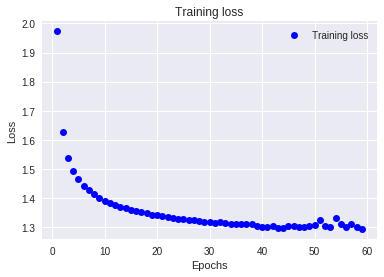

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The plot shows that the loss generally decreases, but there are occasional burst of deteriorating loss. In our case, the lowest loss is at epoch 59, so let's load the weights saved at 59 epochs and use them to generate new text.

**Note that, if you run this notebook, you will probably obtain different results, and even your loss might be much higher or lower. You may obtain different results every time you run the notebook.**

In [0]:
model.load_weights('generation_model_epoch59.h5')

In [18]:
text_seed = "let me be pardoned, as an old philologist who cannot desist from the mischief"[:maxlen]
print("Text seed:", text_seed)
generate_text(model, text_seed)

Text seed: let me be pardoned, as an old philologist who cannot desist 
------ temperature: 0.2
let me be pardoned, as an old philologist who cannot desist than the enthurdes and the most emotions and stranges and profoundly and strong to the sense of the same tasteness of the same and strong and stranges and stranges of the strong and strong and strong and present and devils and desires of the spirit and the most experience of the sense of the same every problem from the same and profoundly and the strong and strong and sense of the same and strong 
------ temperature: 0.5
let me be pardoned, as an old philologist who cannot desist and reverent to the most higher and soul respect that one of the hrile and demands and so the descreat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


es and speaking interpretation and discoundened of the most possession and first, and of the anding and course of the same taste of the frerihion to truth and principle and conception of the strict to make the problem in most even and in the sense believed that has not only a thing of sympathy and
------ temperature: 1.0
let me be pardoned, as an old philologist who cannot desist "in"jeace of keek bravery philosophy freddories of age, even in some feelingss" in constitutely scholars his is another, mack of vices profoundly to the
intellects against one's neaves) that "stenled-like all embed, to assimace which is
like him moral, in
the man, his
disciplinally himself one covers of any one are thorough the soul still for the means
of one
thereby above all norming, things to a
------ temperature: 1.2
let me be pardoned, as an old philologist who cannot desist if a hatter baldgness
of general his uabicaray in markers and full especially. only it
is at one what seo on a tasmeptitiston agains


As you can see, a low temperature results in extremely repetitive and predictable text, but where local structure is highly realistic: in 
particular, most words (a word being a local pattern of characters) are real English words. With higher temperatures, the generated text 
becomes more interesting, surprising, even creative; it may sometimes invent completely new words that sound somewhat plausible (such as 
"eterned" or "troveration"). With a high temperature, the local structure starts breaking down and most words look like semi-random strings 
of characters. Without a doubt, here 0.5 is the most interesting temperature for text generation in this specific setup. Always experiment 
with multiple sampling strategies! A clever balance between learned structure and randomness is what makes generation interesting.


For your reference, below is the original text by Nietzsche:

```
22. Let me be pardoned, as an old philologist who cannot desist from
the mischief of putting his finger on bad modes of interpretation, but
"Nature's conformity to law," of which you physicists talk so proudly,
as though--why, it exists only owing to your interpretation and bad
"philology." It is no matter of fact, no "text," but rather just a
naively humanitarian adjustment and perversion of meaning, with which
you make abundant concessions to the democratic instincts of the modern
soul! 
```

Note that by training a bigger model, longer, on more data, you can achieve generated samples that will look much more coherent and 
realistic than ours. But of course, don't expect to ever generate any meaningful text, other than by random chance: all we are doing is 
sampling data from a statistical model of which characters come after which characters. Language is a communication channel, and there is 
a distinction between what communications are about, and the statistical structure of the messages in which communications are encoded. To 
evidence this distinction, here is a thought experiment: what if human language did a better job at compressing communications, much like 
our computers do with most of our digital communications? Then language would be no less meaningful, yet it would lack any intrinsic 
statistical structure, thus making it impossible to learn a language model like we just did.




## Take aways

* We can generate discrete sequence data by training a model to predict the next tokens(s) given previous tokens.
* In the case of text, such a model is called a "language model" and could be based on either words or characters.
* Sampling the next token requires balance between adhering to what the model judges likely, and introducing randomness.
* One way to handle this is the notion of _softmax temperature_. Always experiment with different temperatures to find the "right" one.